# Monte Carlo Simulation to estimate the Value at Risk (VaR) of a single stock portfolio and multi-asset portfolio.

## What is Value at Risk (VaR) and Conditional Value at Risk (CVaR)
VaR is a measure of loss of investment. A 5% confidence interval of 10% VaR means we have 95% confidence that will not lose more than 5%. CVaR, also known as __expected shortfall__, is the expected amount "loss" if we have crossed the VaR boundary. 

# VaR and CVaR of __single__ stock portfolio using Monte Carlo (MC) simulation on Geometric Brownian Motion (GBM)

In [128]:
# importing dependencies
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Geometric Brownian Motion

In the previous project named `GBM_MS_predictors.ipynb` we have shown how to derive the GBM formula and how to implement it. So we will reuse the code from that project.

In [129]:
# the implementation of BM and GBM from previous projects 
def BM(type = 'plot',*, time, steps, samples):
    n = steps+1
    T = time 
    d = samples 
    times = np.linspace(0, T, n)
    dB = np.random.normal(0, times[1], size = (n-1, d)) # n-1 rows because B0 is 0, so we exclude that 
    B0 = np.zeros(shape = (1,d)) 
    Bt = np.concatenate((B0, np.cumsum(dB, axis = 0)), axis = 0)
    if type == 'plot':
        plt.plot(times, Bt)
        plt.show()
    elif type == 'arrays':
        return times, Bt
    else:
        raise 'Type Error'
    
def GBM(vis = True, *, S0, time, steps, samples, drift, vol):
    times, Bt = BM(type = 'arrays', time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp(drift * times_d + vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.show()
        return times, St
    elif not vis: 
        return times, St
    else:
        raise 'Type Error'


In [130]:
# reading S&P500 data from the past 2 years 
sp500 = yf.Ticker('^GSPC').history(period = 'max')[-252:]
sp500 = sp500.drop(columns = ['Open', 'Volume', 'High', 'Low', 'Dividends', 'Stock Splits']) 
sp500.head()


,Close
Date,
2022-08-18 00:00:00-04:00,4283.740234
2022-08-19 00:00:00-04:00,4228.479980
2022-08-22 00:00:00-04:00,4137.990234
2022-08-23 00:00:00-04:00,4128.729980
2022-08-24 00:00:00-04:00,4140.770020


In [131]:
# Computing columns for log returns (i.e log(S_t / S_{t-1})) and returns (i.e (S_t - S_{t-1}) / S_{t-1})
sp500['log_ratio'] = np.log( sp500['Close'] / sp500['Close'].shift(1))
sp500 = sp500.dropna()
sp500.head()

,Close,log_ratio
Date,,
2022-08-19 00:00:00-04:00,4228.479980,-0.012984
2022-08-22 00:00:00-04:00,4137.990234,-0.021632
2022-08-23 00:00:00-04:00,4128.729980,-0.002240
2022-08-24 00:00:00-04:00,4140.770020,0.002912
2022-08-25 00:00:00-04:00,4199.120117,0.013993


In [132]:
# computing drift coefficient and volatility 
mu = sp500['log_ratio'].mean() # sample mean of log ratio
sigma = sp500['log_ratio'].std(ddof = 1) # sample standard deviation of log ratio

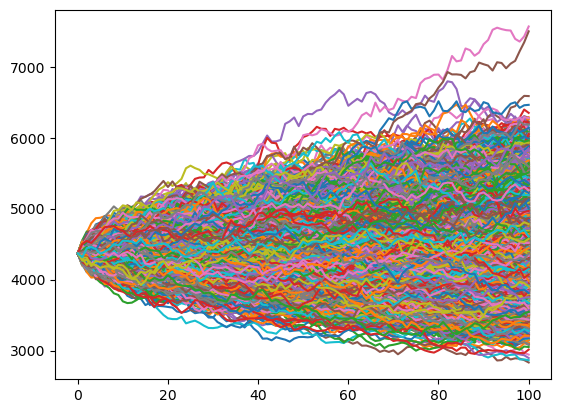

In [133]:
# Now we will produce the brownian motion 
# Let the initial stock price be the last closing price on the data 
S0 = sp500['Close'][-1] 
T = 100 # let's do a forecasting of a hundred days 
n = 100 # discretisation 
d = 10000 # number of samples
times, St = GBM(S0 = S0, drift = mu, vol = sigma, samples = d, time = T, steps = n) 

In [134]:
# now let's define our VaR function that calculate the VaR of a Monte Carlo Simulation at a specific day 

def VaR(paths, vis = False, *, time = -1, alpha = 5):
    """ 
    Input: 
    path ->array of (geometric) Brownian paths
    vis -> For a histogram of the stock price at time inputted 
    time -> the time for which we wish to calculate the VaR 
    alpha -> significance level in % 
    Output: If vis is True, then output the VaR value and a histogram of stock price at time inputted 
    Note that if positive VaR implies loss of money and negative VaR implies gain in stock price    

    """
    result = paths[time]
    var_value = np.percentile(result, alpha)
    if vis:
        fig, ax = plt.subplots(1, 1, figsize = (10, 7), tight_layout = True) 
        ax.hist(result, bins = len(result))
        plt.xlabel('Price of stock paths at time {}'.format(time if time >=0 else len(paths) + time))
        plt.ylabel('Number of paths')
        plt.axvline(x = var_value, color = 'red', linestyle = 'dashed', label = 'Significance level line')
        plt.title('Histogram of stock price at time {}'.format(time if time >= 0 else len(paths) + time))
        plt.legend()
        plt.show()
        # val = result[result <= var_value]
        # print(len(val))
        return paths[0][0] - var_value
    elif not vis:
        return paths[0][0] -var_value


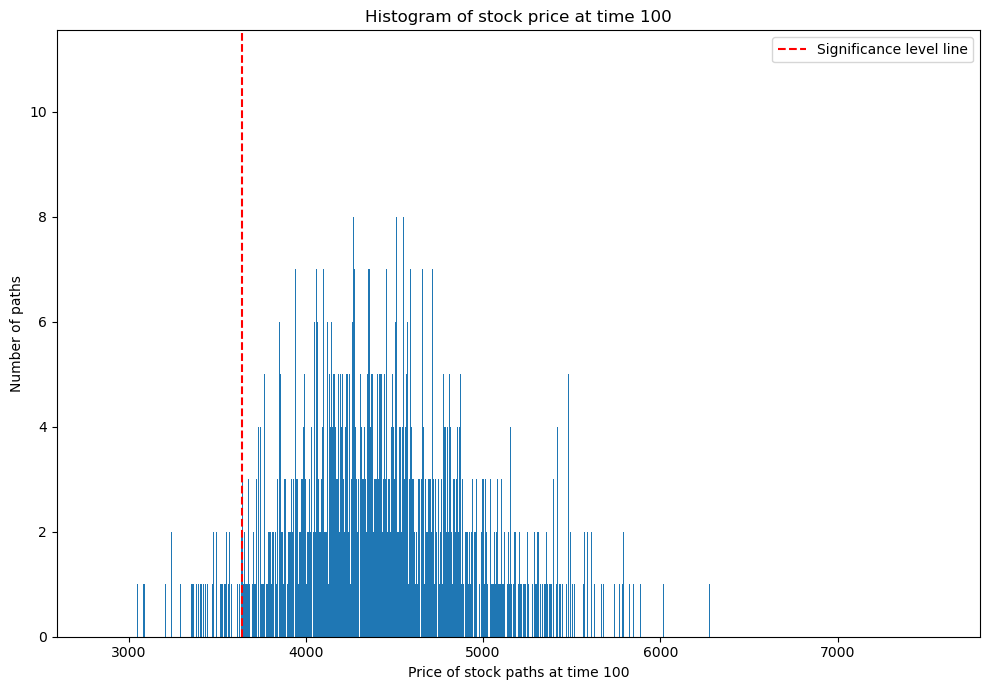

727.5541126787944

In [135]:
VaR(St, vis = True)

In [136]:
# now we can define the function to calculate CVaR
def CVaR(paths, vis = False, *, time = -1, alpha = 5): 
    """
   Input: 
   paths -> (Geometric) Brownian Paths of the stock price 
   vis -> If it's set to True, a histrogram of the paths that is priced less than the VaR threshold will be plotted
   time -> The time we wish to figure our the CVaR at 
   alpha -> significance level in %
   Output: The amount loss in our portfolio given VaR, and a histrogram of the stock paths that results in VaR is plotted if vis is set to True
    """
    result = paths[time]
    var_value = np.percentile(result, alpha)
    cvar_vals = result[result <= var_value]
    # print(len(cvar_vals))
    if not vis: 
        return paths[0][0] - cvar_vals.mean()
    elif vis:
        fig, ax = plt.subplots(1, 1, figsize = (10, 7), tight_layout = True) 
        ax.hist(cvar_vals, bins = len(cvar_vals))
        plt.xlabel('Stock price within VaR at time {}'.format(time if time >= 0 else len(paths) + time)) 
        plt.ylabel('Number of paths')
        plt.title('Histogram of price paths under VaR')
        plt.show()
        return paths[0][0] - cvar_vals.mean()
        


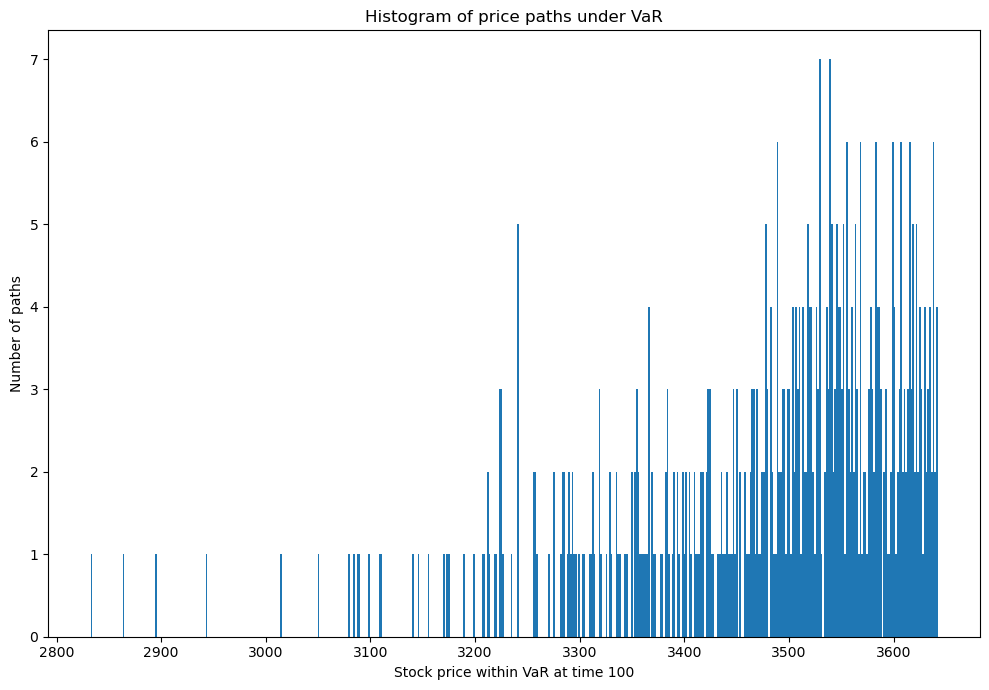

894.9762805137216

In [137]:
CVaR(St, vis = True)

## VaR and CVaR of __multi-asset__ portfolio using Monte Carlo simulations

For a multi-asset portfolio, it is much easier to generate the Monte Carlo simulations paths if we assume the daily return follow a multivariate normal distribution. 

   Now recall that the return on the $ i $-th day is defined by 
   $$ R_i = \cfrac{P_i - P_{i-1}}{P_{i-1}} = \mu \Delta t + \sigma \varepsilon \sqrt{\Delta t}  $$ 
   where
    1. $R_i = \text{return on the }i \text{-th day}$   
    2. $P_i = \text{portfolio value on the }i \text{-th day}$
    3. $\mu  = \text{mean return}$   
    4. $\sigma  = \text{volatility}$  
    4. $\varepsilon \sim N(0,1)$
   for daily returns, we have that $ \Delta t = 1 $ which gives 
   $$ R_t = \mu + \sigma \varepsilon  $$  
   in the case of a multivariate case (for multi-asset portfolio), we have 
   $$ R_t = \mu + L Z_t $$
   where $ L $ is such that $ LL^* = \Sigma $, the lower triangular matrix of the Cholesky decomposition of the covariance matrix of returns between the assets $ \Sigma $, and $ Z_t \sim MVN(\boldsymbol{0}, \boldsymbol{I}) $, where $ \boldsymbol{I}  $  is the identity matrix.

In [138]:
# stocks to include in portfolio 
# i went for BlackRock, Welltower Inc., Morgan Stanley, Goldman Sachs, JP Morgan Chase & Co.
stocks_list = ['BLK', 'WELL', 'MS', 'GS', 'JPM']

# we should also defined the weights on these stocks here 
# we'll use random weights for now 
weights = np.random.random(len(stocks_list))
weights /= np.sum(weights) # normalised the weights 
weights

array([0.02281728, 0.16686623, 0.09057606, 0.36041851, 0.35932191])

In [139]:
# create a dataframe that consist of only the closing price of the stocks in stocks_list 
# we also calculate the mean return 
df = pd.DataFrame()

for stocks in stocks_list:
    data = yf.Ticker(stocks).history(period = 'max')[-504:]
    df[stocks] = data['Close']
    df.index = data.index

df = df.dropna()
df.head()

,BLK,WELL,MS,GS,JPM
Date,,,,,
2021-08-18 00:00:00-04:00,856.564758,79.294540,94.665436,379.019775,146.651062
2021-08-19 00:00:00-04:00,858.340942,79.087601,93.235077,374.049103,145.425659
2021-08-20 00:00:00-04:00,871.057678,79.219284,94.104500,376.235046,145.840393
2021-08-23 00:00:00-04:00,881.210205,79.181664,95.506813,381.538330,147.706787
2021-08-24 00:00:00-04:00,882.473328,79.463852,96.376236,388.295654,148.621109


In [140]:
# now let's calculate the mean returns and covariance of the above stocks
df_pctc  = df.pct_change()
df_pctc = df_pctc.dropna()

meanReturns = df_pctc.mean()
covM = df_pctc.cov()

In [141]:
# constructing the monte carlo simulations
N = 1000 # number of paths simulations 
T = 100 # timeframe in days 

meanM = np.full(shape = (T, len(stocks_list)), fill_value = meanReturns).T

P = np.ones(shape = (T+1, N)) # a dummy matrix that will hold our portfolio price
# first row is set to be all ones

P0 = 100000 # initial portfolio value 

L = np.linalg.cholesky(covM) # the lower triangular matrix from Cholesky decomposition

for i in range(N):
    Z = np.random.normal(size = (T, len(stocks_list)))
    dailyReturns = meanM + np.inner(L, Z) 
    P[1:,i] = np.cumprod(np.inner(weights, dailyReturns.T)+1)
    P[:, i] = P[:, i] * P0

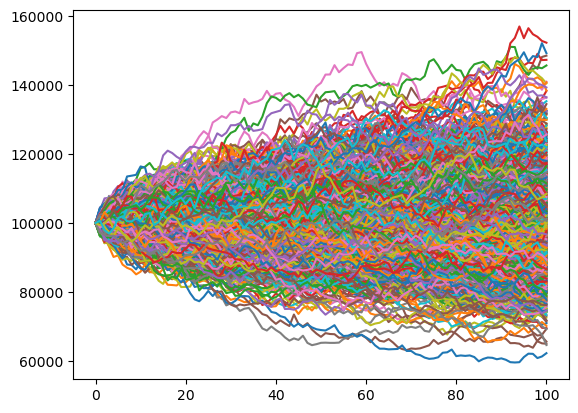

In [142]:
# plotting our Monte Carlo Simulation of portolio value 
plt.plot(P)
plt.show()

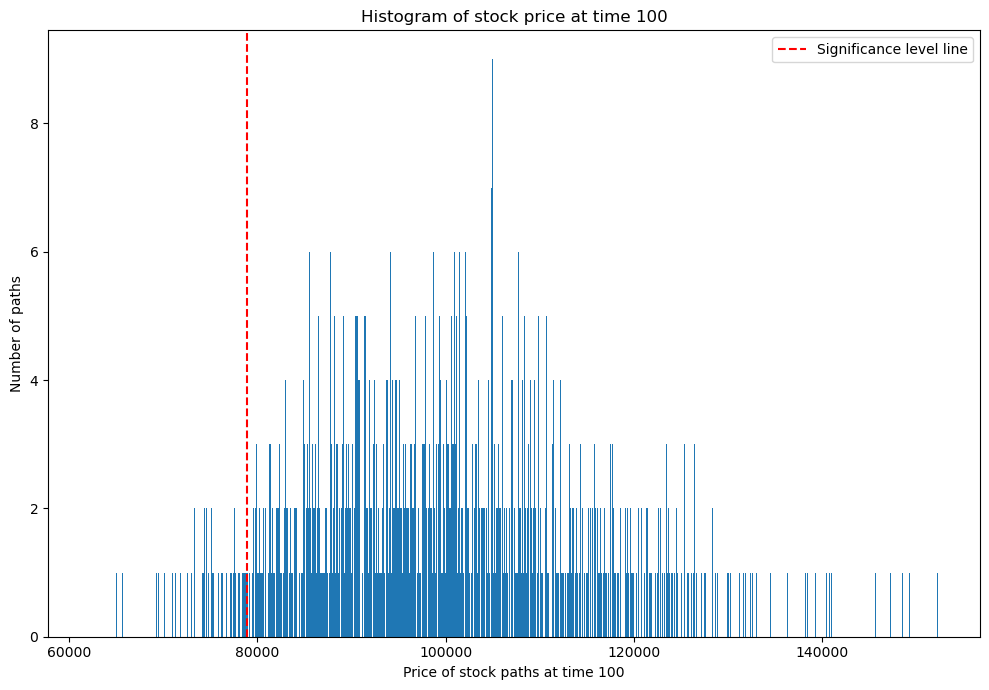

21093.474291552207

In [143]:
# we can just reuse the VaR and CVaR functions defined 
# for example purposes we will compute the VaR and CVaR at day 100 (the last day)
# %matplotlib notebook 
VaR(P, vis = True)

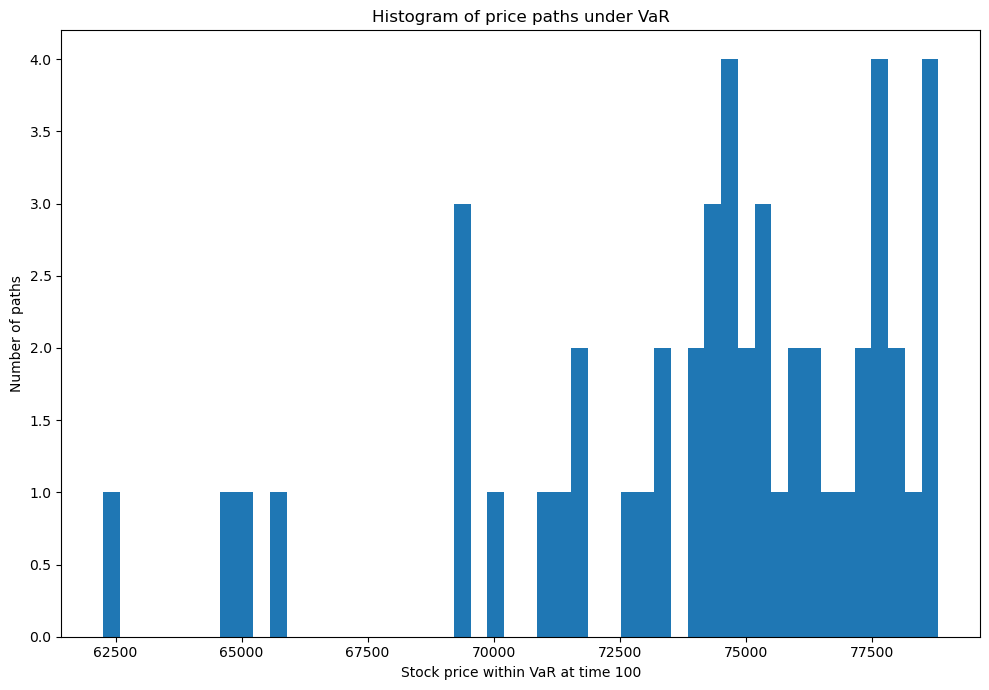

25844.045435070162

In [144]:
CVaR(P, vis = True)